# Hello Chainer

**chainerとは**：
オープンソースのディープラーニングフレームワーク．
Neural Networkの設計・訓練・評価などに必要な一連の実装を容易にできる．

In [0]:
import chainer

In [20]:
chainer.print_runtime_info()

Platform: Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 6.5.0
ChainerX: Not Available
NumPy: 1.18.3
CuPy:
  CuPy Version          : 6.5.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10010
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10010
  cuDNN Build Version   : 7603
  cuDNN Version         : 7603
  NCCL Build Version    : 2402
  NCCL Runtime Version  : 2402
iDeep: 2.0.0.post3


## Chainerの流れ
- データセットの用意
- ネットワークを決める
- 目的関数を決める
- 最適化手法を洗濯する
- ネットワークを訓練する

### Iris Dataset

In [21]:
from sklearn.datasets import load_iris
x, t = load_iris(return_X_y = True)
print('x: ', x.shape)
print('t: ', t.shape)

x:  (150, 4)
t:  (150,)


**Chainerのデフォルトでは，numpy.int32にデータ型を直さねばいかん**

In [0]:
x = x.astype('float32')
t = t.astype('int32')

In [0]:
# データセットを分割するモジュールの読み込み
from sklearn.model_selection import train_test_split

x_train_val, x_test, t_train_val, t_test = train_test_split(x, t, test_size=0.3, random_state=0)

In [0]:
x_train, x_val, t_train, t_val = train_test_split(x_train_val, t_train_val, test_size=0.3, random_state=0)

In [0]:
import chainer.links as L
import chainer.functions as F

## Sequentialによるネットワーク定義：
Sequentialクラスを利用して
- 全結合層が3つ
- 活性化関数にReLU関数を利用
- 隠れ層は任意の値．ここでは10とする．

としたネットワークを作る


In [0]:
# 入力次元が3，　出力次元数が2の全結合層
l = L.Linear(3, 2)

In [0]:
# Irisデータは入力変数が4つ，クラス数が3つ
from chainer import Sequential

# netとしてインスタンス化
n_input = 4
n_hidden = 10
n_output = 3

net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

**目的関数を決める**

訓練の際に利用する目的関数を定義する．
今回は分類タスクによく利用される目的関数である
**交差エントロピー**を使用する．
⚠️softmac_cross_entropy()

**最適化手法を選択する**
確率的勾配降下法(SGD)を利用する
- lr: 学習率としてインスタンスに
- optimaizerという名前にする

In [0]:
optimizer = chainer.optimizers.SGD(lr = 0.01)

In [29]:
# optimizerにnetをセットしてnetパラメータが確率的勾配降下法で更新されるようにする．
optimizer.setup(net)

In [0]:
n_epoch = 30
n_batchsize = 16

In [0]:
import numpy as np

# ログの保存
results_train = {
    'loss': [],
    'accuracy': [] 
}
results_valid = {
    'loss': [],
    'accuracy': []
}

In [32]:
for epoch in range(n_epoch):
  # datasetを並び替えた順番を取得
  order = np.random.permutation(range(len(x_train)))

  # 各パッチ毎の目的関数の出力と分類制度の保存用
  loss_list = []
  accuracy_list = []

  # range(start, stop, step)
  for i in range(0, len(order), n_batchsize):
    # batch
    index = order[i : i+n_batchsize]
    x_train_batch = x_train[index, :]
    t_train_batch = t_train[index]

    # 予測値
    y_train_batch = net(x_train_batch)

    # 目的関数を適用して分類制度を計算
    loss_train_batch = F.softmax_cross_entropy(y_train_batch, t_train_batch)
    accuracy_train_batch = F.accuracy(y_train_batch, t_train_batch)

    loss_list.append(loss_train_batch.array)
    accuracy_list.append(accuracy_train_batch.array)

    # 勾配のリセットと勾配の計算
    net.cleargrads()
    loss_train_batch.backward()

    # パラメータの更新
    optimizer.update()

    # count up
    

  # training dataに対する目的関数の出力と分類精度を計算
  loss_train = np.mean(loss_list)
  accuracy_train = np.mean(accuracy_list)

  # 1epoch終えたら，検証データで評価
  # 検証データで予測値を出力
  with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_val = net(x_val)

  # 目的関数を適用し分類精度を計算
  loss_val = F.softmax_cross_entropy(y_val, t_val)
  accuracy_val = F.accuracy(y_val, t_val)

  print(f'epoch: {epoch}, loss(train): {loss_train}, loss(valid): {loss_val.array}')

  # save log
  results_train['loss'] .append(loss_train)
  results_train['accuracy'] .append(accuracy_train)
  results_valid['loss'].append(loss_val.array)
  results_valid['accuracy'].append(accuracy_val.array)




epoch: 0, loss(train): 1.6138916015625, loss(valid): 1.1189676523208618
epoch: 1, loss(train): 1.1224472522735596, loss(valid): 1.0310301780700684
epoch: 2, loss(train): 1.009491205215454, loss(valid): 1.0025357007980347
epoch: 3, loss(train): 0.9753974080085754, loss(valid): 0.9821068048477173
epoch: 4, loss(train): 0.9472605586051941, loss(valid): 0.9621369242668152
epoch: 5, loss(train): 0.9280592203140259, loss(valid): 0.9425128102302551
epoch: 6, loss(train): 0.9069409370422363, loss(valid): 0.9159604907035828
epoch: 7, loss(train): 0.8763841390609741, loss(valid): 0.8925830125808716
epoch: 8, loss(train): 0.863972544670105, loss(valid): 0.8668349385261536
epoch: 9, loss(train): 0.8386678695678711, loss(valid): 0.8320990800857544
epoch: 10, loss(train): 0.8016650080680847, loss(valid): 0.804107666015625
epoch: 11, loss(train): 0.7757325172424316, loss(valid): 0.7728837728500366
epoch: 12, loss(train): 0.7646920084953308, loss(valid): 0.7490090131759644
epoch: 13, loss(train): 0.75

上のコードで示したように、Chainer では勾配を計算する前に net.cleargrads() を実行し、一つ前の勾配を削除した後、loss_train_batch.backward() で勾配を計算します。

また、検証データに対して予測値の計算を行う際には、chainer.using_config('train', False) と chainer.using_config('enable_backprop', False) の 2 つのスコープを指定しています（注釈4）。

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt


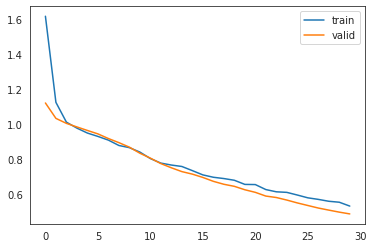

In [34]:
# 目的関数の出力（loss）
import seaborn as sns
sns.set_style('white')
plt.plot(results_train['loss'], label ='train')
plt.plot(results_valid['loss'], label='valid')
plt.legend()

グラフをみると訓練が進むにつれて目的関数の出力値（誤差）が減っていってるので訓練が進んでいったと考えられる．

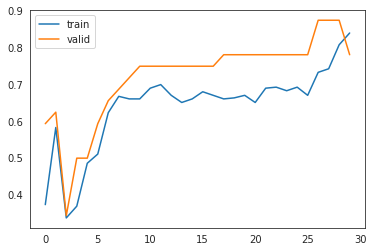

In [35]:
# 分類精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示

こちらもうまくいったとわかる

## テストデータを用いた評価

In [36]:
# テストデータで予測値を計算
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)

accuracy_test = F.accuracy(y_test, t_test)
accuracy_test.array

array(0.64444447, dtype=float32)

In [0]:
chainer.serializers.save_npz('my_iris.net', net)

In [38]:
!ls

drive  my_iris.net  sample_data


## trained networkを用いた推論
テストデータに適用してみる

In [0]:
loaded_net = Sequential(
    L.Linear(n_input, n_hidden), F.relu,
    L.Linear(n_hidden, n_hidden), F.relu,
    L.Linear(n_hidden, n_output)
)

In [0]:
chainer.serializers.load_npz('my_iris.net', loaded_net)

In [0]:
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = loaded_net(x_test)

In [42]:
np.argmax(y_test[0,:].array)

2